# Gaussian naive Bayes classifier for Titanic dataset

## 1. Import thư viện cần thiết

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

%matplotlib inline
# Suppress warnings
warnings.filterwarnings("ignore")

## 2. Đọc dữ liệu từ Titanic_train.csv

In [3]:
train_raw = pd.read_csv('Titanic_train.csv')
test_raw = pd.read_csv('Titanic_test.csv')
test_ids = test_raw['PassengerId'].values

# Kết hợp dữ liệu train và test.
train_raw['train'] = 1
test_raw['train'] = 0
data = train_raw.append(test_raw, sort=False)

## 3. Phân tích dữ liệu

In [4]:
data.shape

(1309, 13)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  train        1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.2+ KB


In [48]:
data.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
train            int64
dtype: object

In [49]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [50]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train'],
      dtype='object')

In [51]:
data.Survived.value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

## 4. Tiền xử lý

In [1]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
target = 'Survived'

data = data[features + [target] + ['train']]
# Chuyển các cột qua giá trị số
data['Sex'] = data['Sex'].replace(["female", "male"], [0, 1])
data['Embarked'] = data['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])
data['Age'] = pd.qcut(data['Age'].rank(method='first'), 10, labels=False)

NameError: name 'data' is not defined

In [53]:
# Chia data thành tập train và test
train = data.query('train == 1')
test = data.query('train == 0')

# Bỏ các giá trị bị thiếu ra khỏi tập train
train.dropna(axis=0, inplace=True)
labels = train[target].values

In [54]:
train.shape

(712, 9)

In [55]:
train.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,2.0,1.0,7.2500,0,3,1,1,0.0,1
1,7.0,2.0,71.2833,0,1,0,1,1.0,1
2,4.0,1.0,7.9250,0,3,0,0,1.0,1
3,6.0,1.0,53.1000,0,1,0,1,1.0,1
4,6.0,1.0,8.0500,0,3,1,0,0.0,1


In [56]:
train.shape

(712, 9)

In [57]:
train.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,2.0,1.0,7.2500,0,3,1,1,0.0,1
1,7.0,2.0,71.2833,0,1,0,1,1.0,1
2,4.0,1.0,7.9250,0,3,0,0,1.0,1
3,6.0,1.0,53.1000,0,1,0,1,1.0,1
4,6.0,1.0,8.0500,0,3,1,0,0.0,1


## 5. Trực quan hóa

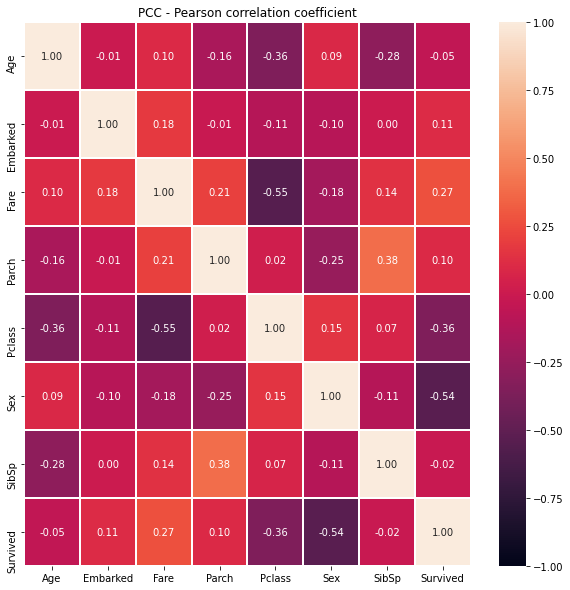

In [58]:
columns = train[features + [target]].columns.tolist()
nColumns = len(columns)
result = pd.DataFrame(np.zeros((nColumns, nColumns)), columns=columns)

# Áp dụng Pearson correlation cho từng cặp features.
for col_a in range(nColumns):
    for col_b in range(nColumns):
        result.iloc[[col_a], [col_b]] = pearsonr(train.loc[:, columns[col_a]], train.loc[:,  columns[col_b]])[0]
        
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(result, yticklabels=columns, vmin=-1, vmax=1, annot=True, fmt='.2f', linewidths=.2)
ax.set_title('PCC - Pearson correlation coefficient')
plt.show()

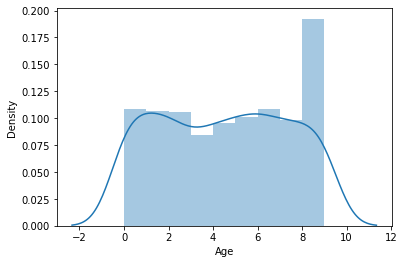

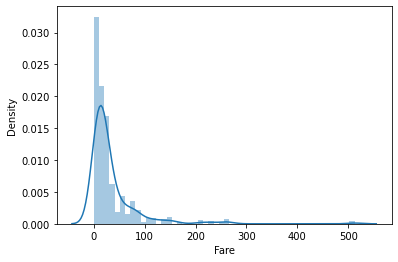

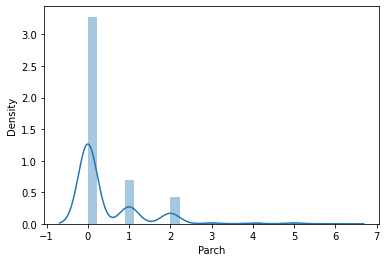

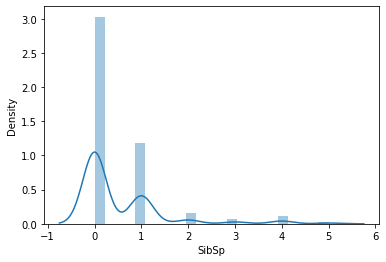

In [59]:
continuous_numeric_features = ['Age', 'Fare', 'Parch', 'SibSp']
for feature in continuous_numeric_features:
    sns.distplot(train[feature])
    plt.show()

In [60]:
train.drop(['train', target, 'Pclass'], axis=1, inplace=True)
test.drop(['train', target, 'Pclass'], axis=1, inplace=True)

In [61]:
# Tách dữ liệu trong tập train và xác thực (80% ~ 20%)
X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.2, random_state=1)

In [62]:
# Chia đôi tập train
X_train1, X_train2, Y_train1, Y_train2 = train_test_split(X_train, Y_train, test_size=0.3, random_state=12)

## 6. Xây dựng mô hình phân lớp GaussianNB

In [63]:
classifier = GaussianNB()

In [64]:
classifier.fit(X_train2, Y_train2)

GaussianNB()

In [67]:
# Hàm phụ trợ
def cross_validate(estimator, train, validation):
    X_train = train[0]
    Y_train = train[1]
    X_val = validation[0]
    Y_val = validation[1]
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(train_predictions, Y_train)
    train_recall = recall_score(train_predictions, Y_train)
    train_precision = precision_score(train_predictions, Y_train)

    val_predictions = classifier.predict(X_val)
    val_accuracy = accuracy_score(val_predictions, Y_val)
    val_recall = recall_score(val_predictions, Y_val)
    val_precision = precision_score(val_predictions, Y_val)

    print('Model metrics')
    print('Accuracy  Train: %.2f, Validation: %.2f' % (train_accuracy, val_accuracy))
    print('Recall    Train: %.2f, Validation: %.2f' % (train_recall, val_recall))
    print('Precision Train: %.2f, Validation: %.2f' % (train_precision, val_precision))

In [68]:
classifier.partial_fit(X_train1, Y_train1)
print('Metrics with only 30% of train data')
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with only 30% of train data
Model metrics
Accuracy  Train: 0.80, Validation: 0.76
Recall    Train: 0.78, Validation: 0.70
Precision Train: 0.69, Validation: 0.69


In [69]:
GaussianNB(priors=None, var_smoothing=1e-09)

GaussianNB()

In [70]:
print('Metrics with the remaining 70% of train data')
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with the remaining 70% of train data
Model metrics
Accuracy  Train: 0.80, Validation: 0.76
Recall    Train: 0.78, Validation: 0.70
Precision Train: 0.69, Validation: 0.69


In [71]:
print('Probability of each class')
print('Survive = 0: %.2f' % classifier.class_prior_[0])
print('Survive = 1: %.2f' % classifier.class_prior_[1])

Probability of each class
Survive = 0: 0.60
Survive = 1: 0.40


In [72]:
print('Mean of each feature per class')
print('               Age         Embarked   Fare         Parch       Sex         SibSp')
print('Survive = 0: %s' % classifier.theta_[0])
print('Survive = 1: %s' % classifier.theta_[1])

Mean of each feature per class
               Age         Embarked   Fare         Parch       Sex         SibSp
Survive = 0: [ 4.6597582   1.23661485 23.27259568  0.3955095   0.8566494   0.54058722]
Survive = 1: [ 4.30670103  1.32216495 53.65236443  0.53865979  0.31958763  0.50257732]


In [73]:
print('Variance of each feature per class')
print('Survive = 0: %s' % classifier.sigma_[0])
print('Survive = 1: %s' % classifier.sigma_[1])

Variance of each feature per class
Survive = 0: [8.29701904e+00 2.80803835e-01 8.66862297e+02 8.57392021e-01
 1.22804068e-01 1.11536763e+00]
Survive = 1: [8.80026724e+00 2.69923947e-01 5.28208645e+03 6.91807250e-01
 2.17454237e-01 4.56181785e-01]


In [74]:
# Apply the model on the test data and create submission
test.fillna(test.mean(), inplace=True)
test_predictions = classifier.predict(test)
submission = pd.DataFrame({'PassengerId': test_ids})
submission['Survived'] = test_predictions.astype('int')
submission.to_csv('submission.csv', index=False)
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
